# Two-dimensional shallow water equations
v1.68, 14 March 2018, by Brian Fiedler

tweeked September 2023
$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output
import time as Time
import math
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer

Here are the two-*dimensional* shallow-water equations:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x}  + v \frac{\partial u}{\partial y}= - g\frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= - g\frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

As we did in the one-dimensional equations, we choose not to use meters as the 
length scale or seconds as the time scale.  Instead, we use length scale and time scales intrinsic to the system.
We define dimensionless quantities with a star:

$$
x \equiv x^* L  
\qquad y \equiv y^* L
\qquad h \equiv h^* H 
\qquad u \equiv u^* c 
\qquad v \equiv v^* c 
\qquad t \equiv t^* \frac{L}{c}
$$

Recall $c \equiv \sqrt{gH}$. Substitute the above definitions into the above PDEs and we get the dimensionless equations with a blizzard of $^*$. 

$$
\frac{\partial u^*}{\partial t^*} + u^* \frac{\partial u^*}{\partial x^*} + v^* \frac{\partial u^*}{\partial y^*}= - \frac{\partial h^*}{\partial x^*} + f^*v^*
$$

$$
\frac{\partial v^*}{\partial t^*} + u^* \frac{\partial v^*}{\partial x^*}  + v^* \frac{\partial v^*}{\partial y^*}= - \frac{\partial h^*}{\partial y^*} - f^*u^*
$$

$$
\frac{\partial h^*}{\partial t^*} = - \frac{\partial (u^*h^*) }{\partial x^*} - \frac{\partial (v^*h^*) }{\partial y^*}
$$

$$
f^* = \frac{L}{c} f
$$

$\frac{L}{c}$ is the time required for a gravity wave to traverse the domain.  Recall that $f=2\Omega$ where $\Omega$ is the rotation rate of the domain, about the vertical access. So $f^*$ is a measure of the angular displacement of the domain in the time required for a wave to traverse the domain.  As we move forward with working with the dimensionless equations, we drop the $^*$, and leave them as implied:


$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y}= - \frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}= - \frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

Note that $g$ has disappeared but $f$ has not. **Be sure to keep in mind the $f$ is actually $f^*$ in the above equations.**


Assuming a square domain, the dimensionless boundary conditions for $u(x,y,t)$, $v(x,y,t)$ and $h(x,y,t)$ are:

$$
u(0,y,t)=0 \qquad u(1,y,t)=0 \qquad v(x,0,t)=0 \qquad v(x,1,t)=0
$$

$$
\frac{\partial h}{\partial x}(0,y,t)=0 \qquad \frac{\partial h}{\partial x}(1,y,t)=0 \qquad \frac{\partial h}{\partial y}(x,0,t)=0 \qquad \frac{\partial h}{\partial y}(x,1,t)=0
$$

In [3]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

In [4]:
# dqdt requires a list of the time derivatives for q, stored 
# in order from present to the past
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")

In [5]:
# interpolates and extrapolates from the p-grid to the u-grid
def p2u(p):
    u=np.zeros((p.shape[0]+1,p.shape[1]+1))
    u[1:-1,1:-1] = .25*( p[:-1,:-1]+p[1:,:-1]+\
                        p[1:,1:]+p[:-1:,1:] )
    u[1:-1,0] = .5* (p[:-1,0] + p[1:,0])
    u[1:-1,-1] = .5* (p[:-1,-1] + p[1:,-1])
    u[0,1:-1] = .5* (p[0,:-1] + p[0,1:])
    u[-1,1:-1] = .5* (p[-1,:-1] + p[-1,1:])
    u[0,0]=p[0,0]
    u[0,-1]=p[0,-1]
    u[-1,0]=p[-1,0]
    u[-1,-1]=p[-1,-1]
    return u
#############################################################
# interpolates u-grid to the p-grid
def u2p(u):
    return .25*( u[:-1,1:] + u[1:,1:] + u[:-1,:-1] + u[1:,:-1])
#############################################################
# calculate du/dx + dv/dy on the p-grid points
def divergence(u,v,dx,dy):
    div = .5*( u[:-1,1:] + u[1:,1:] - u[:-1,:-1] - u[1:,:-1])/dx + \
          .5*( v[1:,:-1] + v[1:,1:] - v[:-1,:-1] - v[:-1,1:])/dy
    return div
#############################################################
#STUDENTS: complete the vorticity function, which is very similar to divergence
def vorticity(u,v,dx,dy):
    vor = u[1:,1:] # Students fix this! Hint cut&paste div, then modify
    return vor
######################################################################### 
# third-order upwind advection of q by u and v
def advect3(q,u,v,dx,dy): 
    
    dqdt = np.zeros(q.shape)
    
    dqmx = np.zeros(q.shape)
    dqpx = np.zeros(q.shape)
    dqmy = np.zeros(q.shape)
    dqpy = np.zeros(q.shape)
    
    dqmx[:,1]  = -q[:,0] + q[:,1] # 1st order (upwind side is at left wall)
    dqmx[:,2:-1] = (q[:,:-3] - 6*q[:,1:-2] + 3*q[:,2:-1] + 2*q[:,3:])/6. # 3rd order, minus side
    dqpx[:,-2] = -q[:,-2] + q[:,-1] # 1st order (upwind side at right wall)
    dqpx[:,1:-2] = (-2*q[:,0:-3] - 3*q[:,1:-2] + 6*q[:,2:-1] -1*q[:,3:])/6. #3rd order, plus side

    dqmy[1,:]  = -q[0,:] + q[1,:] # 1st order (upwind side at bottom wall)
    dqmy[2:-1,:] =  (q[:-3,:] - 6*q[1:-2,:] + 3*q[2:-1,:] + 2*q[3:,:])/6. # 3rd order, minus side
    dqpy[-2,:] = -q[-2,:] + q[-1,:] # 1st order (upwind side at top wall)
    dqpy[1:-2,:] = ( - 2*q[0:-3,:]  - 3*q[1:-2,:] + 6*q[2:-1,:] - q[3:,:] )/6. # 3rd order, plus side

    dqdx = np.where(u>0.,dqmx,dqpx)/dx # upwind, emphasize side from where fluid is coming from
    dqdy = np.where(v>0.,dqmy,dqpy)/dy # ditto
    
    dqdt += -u*dqdx
    dqdt += -v*dqdy
    
    return dqdt
####################################
# Calculates pressure gradient force on the u-grid points.
# Note calculation on the boundaries assumes the pressure gradient force
# along boundary is the same as calculated 1/2 a grid point away from the boundary.
def pgf(p,dx,dy):
    dudt = np.zeros( (p.shape[0]+1, p.shape[1]+1 ) ) #initialize an array on the u-grid
    dvdt = np.zeros( dudt.shape ) # ditto

    dpy =  p[1:,:]-p[:-1,:] # delta p in the y direction
    dvdt[1:-1,1:-1] = -.5* ( dpy[:,:-1] + dpy[:,1:] ) /dy #average to put on u-grid
    dvdt[1:-1,0] =  -dpy[:,0] /dy #dvdt along left boundary
    dvdt[1:-1,-1] = -dpy[:,-1] /dy #dvdt along right boundary

    dpx = p[:,1:]-p[:,:-1] # delta p in the x direction
    dudt[1:-1,1:-1] = -.5* ( dpx[:-1,:] + dpx[1:,:] ) /dx #average to put on u-grid
    dudt[0,1:-1] =  -dpx[0,:] /dx #dudt along bottom boundary
    dudt[-1,1:-1] = -dpx[-1,:] /dx #dudt along top boundary

    return dudt,dvdt

In [6]:
# make the grid
Nx = 101 # number of x grid points for u and v
Ny = 101 # number of y grid points for u and v
xmax = 1. # 0 <= x <= xmax
ymax = 1. # 0 <= y <= ymax
dx = xmax/(Nx-1.) # grid width
dy = ymax/(Ny-1.)
x1u = np.linspace(0,xmax,Nx)
y1u = np.linspace(0,ymax,Ny)
x1p = .5*(x1u[:-1]+x1u[1:]) # pgrid is between u-grid
y1p = .5*(y1u[:-1]+y1u[1:]) # ditto. And pgrid is (Nx-1)x(Ny-1) 
# We need 2-D arrays of grid point coordinates, for plotting:
xu,yu = np.meshgrid(x1u,y1u) # x and y locations on the u-grid
xp,yp = np.meshgrid(x1p,y1p) # x and y locations on the p-grid

You can delete the next 3 cells after you understand what is in the arrays `xu`, `yu`, `xp` and `yp`.

In [7]:
print(xu.shape)
print(xu)

(101, 101)
[[0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 ...
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]
 [0.   0.01 0.02 ... 0.98 0.99 1.  ]]


In [8]:
print(xp.shape)
print(xp)

(100, 100)
[[0.005 0.015 0.025 ... 0.975 0.985 0.995]
 [0.005 0.015 0.025 ... 0.975 0.985 0.995]
 [0.005 0.015 0.025 ... 0.975 0.985 0.995]
 ...
 [0.005 0.015 0.025 ... 0.975 0.985 0.995]
 [0.005 0.015 0.025 ... 0.975 0.985 0.995]
 [0.005 0.015 0.025 ... 0.975 0.985 0.995]]


In [9]:
print(yu)

[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.02 0.02 0.02 ... 0.02 0.02 0.02]
 ...
 [0.98 0.98 0.98 ... 0.98 0.98 0.98]
 [0.99 0.99 0.99 ... 0.99 0.99 0.99]
 [1.   1.   1.   ... 1.   1.   1.  ]]


Note the convention of meshgrid and matplotlib:  The **first** index controls the variation of $y$, the **second** index controls the variation of $x$. That protocol will also be true for all of our 2-D fields. This may be confusing because when normally write $h(x,y)$ we might expect in a python array `h[j,i]` that `i` controls the y-coordinate, but in fact `i` controls the x-coordinate.

In [10]:
# note how x and y change when i is incremented by 1. (This cell is deletable)
print("xu:" ,xu[1,1], xu[1,2])
print("yu:" ,yu[1,1], yu[1,2])

xu: 0.01 0.02
yu: 0.01 0.01


In [11]:
# make arrays for initial u, v, h
xc = .5*xmax # center of initial Gaussian
yc = .5*ymax # center of iniital Gaussian
gwidth = .1 # Gaussian width
hamp = .2 # amplitude of initial Gaussian
hi =  hamp*np.exp( -((xp-xc)/gwidth)**2  - ((yp-yc)/gwidth)**2 ) #initial h
hi = hi - hi.mean() + 1
ui = 0.*xu #initial u
vi = 0.*xu #initial v

http://matplotlib.org/examples/pylab_examples/contour_demo.html
    

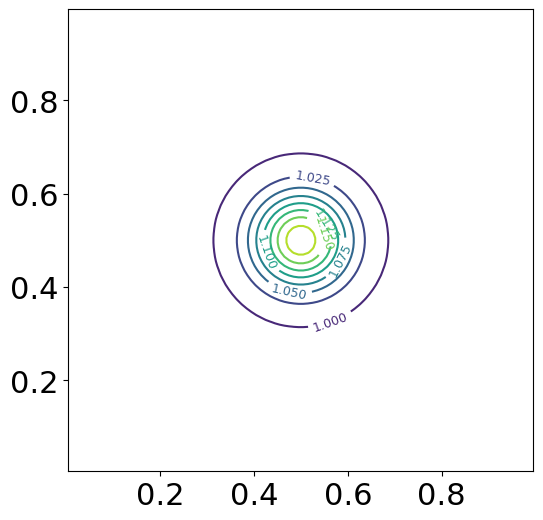

In [12]:
quick,simple = plt.subplots(figsize=(6,6))
CH = simple.contour(xp,yp,hi) #must assign a variable name to the contour plot
plt.clabel(CH, fontsize=9, inline=1);

In [13]:
# needed for contour plots of h in the animation:
lowc = .75 #lowest contour
hic = 1.25 #highest contour
dc = .02  #contour increment
mylevs = [] #store contours
lev = lowc
while lev < hic + 0.1*dc:
    mylevs.append(lev)
    lev += dc

#for arrow plots:
vd = 2 # vector skip (vd=1 plots all arrows)


In [14]:
dgrid = 0.2 # fraction of a grid space a wave is allowed to travel in one time unit
dt = dgrid*dx/1.0 # because wave speed is 1.0 in dimensionless model
print("dt=",dt)
aborder = 3 # Adams-Bashforth order: 1, 2 or 3

dt= 0.002


##  Notes about the simulation below.

* Note that wind vectors are plotted every 2nd grid point, meaning that there are 4 times as many grid points as displayed vectors.  

* The simulation is a bit slow to compute. One reason is that the time step is limited by the gravity waves, which move with speed of 1. 

In [15]:
t=0
nstep=0

u=ui.copy()
v=vi.copy()
h=hi.copy()
dvdta = [None]*3
dhdta = [None]*3
dudta = [None]*3


fcoriolis = 20.
speedmax = 0.05/(1.+fcoriolis/20) # anticipated maximum speed
print(speedmax)


nxc=Nx//2
nyc=Ny//2

vstore = [ h[nyc,nxc] ] # for storing a time series of a value of something in the simulation
#vstore= [ h.mean() ]
tstore = [ t ] # for storing the corresponding time of the value
print(vstore)

expt = '%d,%3.2f,%3.0f,%d' % (aborder, dgrid, fcoriolis, Ny)
print(expt)

0.025
[1.1927193105313754]
3,0.20, 20,101


In [16]:
myfig = plt.figure(figsize=(8,8),facecolor='lightgrey')
ax2 = myfig.add_axes([0.1, 0.1, 0.8, .8*ymax/xmax],frameon=False) # contour axes
ax3 = myfig.add_axes([0.0, 0.1, 0.08, .8]) # for colorbar
ax3.axis('off')
ax2.axis('off')
plt.setp( ax2.get_xticklabels(), visible=False)
plt.close()

you may extend `tstop` and run the next cells repeatedly

In [17]:
tplot = t # next time to make a plot
dplot = .05 # time increment between plots
tstop = 2.0 # stop when t>tstop
print(t,nstep)

0 0


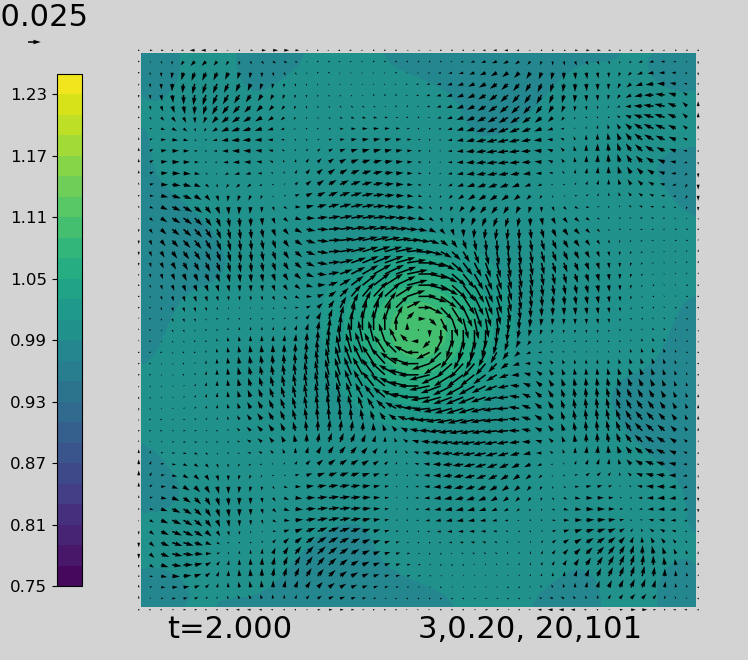

In [18]:
while t < tstop + dt/2.:    
    if tplot-dt/2. < t <tplot+dt/2 : # plot
        ax2.clear()
        CF=ax2.contourf(xp,yp,h,mylevs,zorder=1)
        ax2.axis('off')
        Q=ax2.quiver(xu[::vd,::vd],yu[::vd,::vd],u[::vd,::vd]*ymax/xmax,v[::vd,::vd],
                scale=speedmax*Nx/vd,units='width',zorder=3) #normally ymax/xmax =1 
        stop_clipping(ax2)
        ax2.quiverkey(Q,-.1,.95,speedmax,'{0:7.3f}'.format(speedmax),zorder=4)
        ax2.text(.5,-.05,expt,fontsize=22)
        ax2.text(.05,-.05,'t={0:5.3f}'.format(t),fontsize=22)  
        if t<dt/2.: # only do this once
            mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.4)
            mycbar.ax.yaxis.set_ticks_position('left')
            sooner = mycbar.ax.yaxis.get_ticklabels()
            for boomer in sooner:
                boomer.set_fontsize(12)
        clear_output(wait=True)
        display(myfig) 
        tplot = min(tstop,t + dplot)
        if t<dt/2.: Time.sleep(1.)
    
    hu = p2u(h) # calculate h on the u grid
    
    dhdt = -divergence(u*hu,v*hu,dx,dy)
    
    dudt,dvdt = pgf(h,dx,dy) #pressure gradient force
    
    dudt += advect3(u,u,v,dx,dy) # no option for other than 3rd order 
    dvdt += advect3(v,u,v,dx,dy) 
    
#Coriolis force here:
    dudt += fcoriolis*v
    dvdt += -fcoriolis*u
    dudt[:,0]=0. # boundary condition must be enforced
    dudt[:,-1]=0.
    dvdt[0,:]=0.
    dvdt[-1,:]=0.
#end Coriolis force
    
    dudta = [dudt.copy()] + dudta[:-1]
    dvdta = [dvdt.copy()] + dvdta[:-1]
    dhdta = [dhdt.copy()] + dhdta[:-1]
    nstep += 1
    abnow=min(nstep,aborder)
    u += dt*ab_blend(dudta,abnow)
    v += dt*ab_blend(dvdta,abnow)
    h += dt*ab_blend(dhdta,abnow)
    
    t = t + dt
    vstore.append(h[nyc,nxc])
#    vstore.append( h.mean() )
    tstore.append( t )

    assert u.max()<2.e10, 'kaboom!'

#plt.close() 

1.1927193105313754


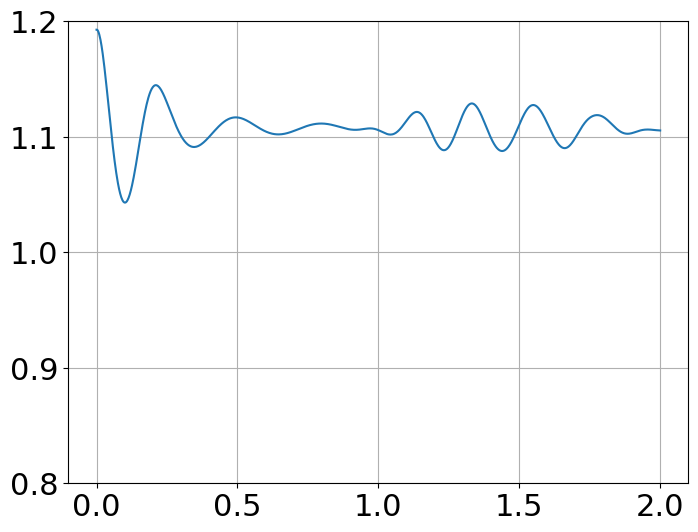

In [19]:
tracefig, trace = plt.subplots(figsize=(8,6))
trace.plot(tstore,vstore)
trace.set_ylim((.8,1.2))
trace.grid()
print(vstore[0])

(0.0, 99.0, 0.0, 99.0)

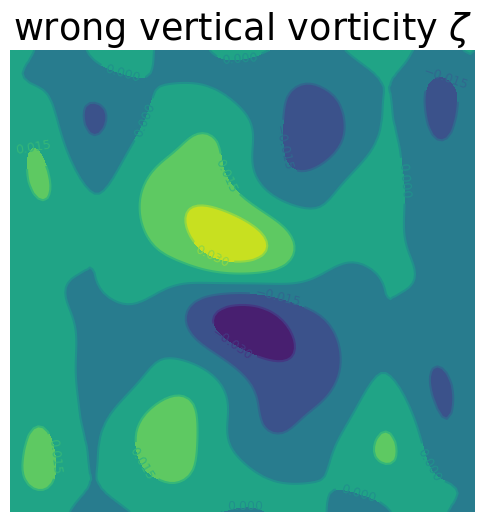

In [20]:
vort=vorticity(u,v,dx,dy) # fix the vorticity function!!
quick,simple = plt.subplots(figsize=(6,6))
# it is possible to use both filled and line contour plots together
simple.contourf(vort) # filled contours
CV = simple.contour(vort) # line contours
plt.clabel(CV, fontsize=9, inline=1) #labels on line contours
simple.set_title('wrong vertical vorticity $\zeta$') #fix title
simple.axis('off')                 

## Student tasks:

### 0.5  Fix the vorticity function.

Then rerun the notebook.

### 1. Derivation of the dimensionless model

Beginning with:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} 
+ v \frac{\partial u}{\partial y}= - g\frac{\partial h}{\partial x} + fv
$$

$$
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} 
+ v \frac{\partial v}{\partial y}= - g\frac{\partial h}{\partial y} - fu
$$

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

Let's assume a square domain of dimensional size $L\times L$.
Using the time and length scales that we used for one-dimensional waves,
derive the following dimensionless equations  **using pencil and paper**.
The whole point of this is $g$ disappears and the boundary conditions will always be
at $x=0$,$x=1$,$y=0$ and $y=1$. 

$$
\frac{\partial u^*}{\partial t^*} + u^* \frac{\partial u^*}{\partial x^*} 
+ v^* \frac{\partial u^*}{\partial y^*}= - \frac{\partial h^*}{\partial x^*} + f^*v^*
$$

$$
\frac{\partial v^*}{\partial t^*} + u^* \frac{\partial v^*}{\partial x^*} 
+ v^* \frac{\partial v^*}{\partial y^*}= - \frac{\partial h^*}{\partial y^*} - f^*u^*
$$

$$
\frac{\partial h^*}{\partial t^*} = - \frac{\partial (u^*h^*) }{\partial x^*} - \frac{\partial (v^*h^*) }{\partial y^*}
$$

### 2. Global conservation of energy

Here is a global conserved quantity for two-dimensional shallow-water waves, a generalization of the energy we derived for one-dimensional waves:

$$ \int_{x=0}^{x=L}\int_{y=0}^{y=L} \left( h\frac{u^2}{2} + h\frac{v^2}{2} + g\frac{h^2}{2} \right)dx\, dy $$

The dimensionless version is:

$$ \int_{x=0}^{x=1}\int_{y=0}^{y=1} \left( h\frac{u^2}{2} + h\frac{v^2}{2} + \frac{h^2}{2} \right)dx\, dy $$

We can write the dimensionless version as

$$
E = KE + PE
$$

where 

$$ KE = \int_{x=0}^{x=1}\int_{y=0}^{y=1} \left( h\frac{u^2}{2} + h\frac{v^2}{2} \right)dx\, dy $$

$$ PE = \int_{x=0}^{x=1}\int_{y=0}^{y=1}  \frac{h^2}{2} dx\, dy $$

Show the numerical (meaning python array) approximation of $E$ is conserved well in the model, meaning though $KE$ and $PE$ vary with time $KE + PE$ varies much less.  Again, evaluate the integrals on the p-grid, and use the `.mean()` array method.

### 3. Conservation of potential vorticity in parcels

From either the dimensionless or dimensional model equations, derive with pencil and paper:

$$
\pdt{\zeta} + u \pd{\zeta}{x} 
+ v \pd{v}{y} = - (f+\zeta) \left( \pd{u}{x} + \pd{v}{y} \right)
$$

or 

$$
\ddt{\zeta} = - (f+\zeta) \left( \pd{u}{x} + \pd{v}{y} \right)
$$

where vertical vorticity $\zeta$ is defined:

$$
\zeta \equiv \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y} 
$$


Show that the volume conservation equation

$$
\frac{\partial h}{\partial t} = - \frac{\partial (uh) }{\partial x} - \frac{\partial (vh) }{\partial y}
$$

can also be written:

$$
\ddt{h}  = - h \left( \pd{u}{x} + \pd{v}{y} \right)
$$

The vorticity equation and volume conservation equation combine to give a conservation of potential vorticity:

$$
\frac{d}{dt}\frac{\zeta+f}{h} = 0
$$

So the potential vorticity $$\frac{\zeta+f}{h}$$ does not change within a parcel of fluid.  

Be careful to understand what it means for a claim that a quantity is *conserved*.  When we say total energy $E$ is conserved, we mean a sum over the whole domain is invariant.  When we say potential vorticity is conserved, we mean the value in moving parcel is invariant.

In our initialization with the height initially stacked up at the center, there is no advection at the center,
so the potential vorticity should be invariant at the center point.

Finish the `vorticity` function.  Set `fcoriolis=20` and then monitor   $\frac{\zeta+f}{h}$ at the central grid point, to investigte if the model keeps it invariant with time.

### 4. Amplitude ot the balanced vortex

The "dome" of fluid initialized at the center of domain collapses when the simulation begins.
It appears that the central height anomaly remains larger as `fcoriolis` is increased. Make a study of the ratio of height anomlay remaining at the center to the initial height anomaly. How does the ratio depend on `fcoriolis`?  A plot and a table might be useful.

### 5.  Instability with high f

For stability and accuracy, the time-step $\Delta t$ is constrained to values that
are small enough to prevent a wave or parcel from moving across more than one grid cell
in one forward time step.

Another constraint is that inertial oscillations must be resolved in time.

For what values of $f\Delta t$ does the model blow up?  Confirm with experiments.